In [8]:
import sys , os
sys.path.append('../')

import dnn.bitwise_ss as bitwise_ss
import dnn.binary_layers as binary_layers
import dnn.bitwise_mlp as bitwise_mlp
import datasets.binary_data as binary_data
import loss_and_metrics.bss_eval as bss_eval
import torch
import torch.nn.functional as F
import numpy as np
import IPython.display as ipd
import soundfile as sf
import seaborn as sns
import pandas as pd
import mir_eval
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl

# Inverse Blues colormap
cdict = {
    'red':   ((0.0,  1.0, 1.0), (1.0,  0.0, 0.0)),
    'green': ((0.0,  1.0, 1.0), (1.0,  .15, .15)),
    'blue':  ((0.0,  1.0, 1.0), (1.0,  0.4, 0.4)),
    'alpha': ((0.0,  0.0, 0.0), (1.0,  1.0, 1.0))}
plt.register_cmap(name='InvBlueA', data=cdict)

# Customize my figure style
plt.rc('figure', figsize=(8,4), dpi=96, facecolor='#FFFFFF00', autolayout=False)
plt.rc('lines', linewidth=1)
plt.rc('axes', axisbelow=True, titlesize=10, titleweight=500, 
   labelsize=9, labelweight=400, linewidth=0.5, facecolor='#FFFFFF00')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes.spines', right=False, top=False)
plt.rc('grid', linestyle='-', linewidth=0.5)

# Get a decent figure font
matplotlib.font_manager._rebuild()
plt.rc('font', family='Avenir Next LT Pro', weight=400, size=9)

# Light colors
plt.rc('axes', edgecolor='#404040')
plt.rc('grid', color='#DDDDDD')
plt.rc('xtick', color='#222222')
plt.rc('ytick', color='#222222')
plt.rc('text', color='#222222')
plt.rc('image', cmap='InvBlueA')
plt.rc('legend', facecolor='#FFFFFF55', framealpha=0.5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Binary Neural Network

In [3]:
def get_audio_output(model, binary_sample, raw_sample):
    mix = raw_sample['mix']
    target = raw_sample['target']
    val_mag, val_phase = stft(mix)
    bmag = torch.FloatTensor(binary_sample['bmag']).unsqueeze(0)
    model_in = flatten(bmag)
    premask = model(model_in)
    premask = unflatten(premask, bmag.size(0), bmag.size(2))
    mask = binary_data.make_binary_mask(premask).squeeze(0)
    estimate = binary_data.istft(val_mag * mask.numpy(), val_phase)
    ipd.display(ipd.Audio(mix, rate=16000))
    ipd.display(ipd.Audio(estimate, rate=16000))
    ipd.display(ipd.Audio(target, rate=16000))

In [4]:
valset = binary_data.DatasetFromDirectory('/media/data/binary_audio/val', template='binary_data*.npz')
raw_valset = binary_data.DatasetFromDirectory('/media/data/binary_audio/val', template='raw_data*.npz')
testset = binary_data.DatasetFromDirectory('/media/data/binary_audio/test', template='binary_data*.npz')
raw_testset = binary_data.DatasetFromDirectory('/media/data/binary_audio/test', template='raw_data*.npz')
print('Number of Binary Validation Examples: ', len(valset))
print('Number of Binary Test Examples: ', len(testset))

Number of Binary Validation Examples:  400
Number of Binary Test Examples:  400


## Bitwise Neural Network Evaluation

In [54]:
# Evaluate real source separation network
mlp = bitwise_mlp.BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], activation=torch.tanh)
mlp.load_state_dict(torch.load('../models/net_tanh.model'))
mlp.eval()
loss, met = bitwise_ss.evaluate(mlp, testset, raw_testset, loss=F.binary_cross_entropy_with_logits)
sdr, sir, sar = bss_metrics.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, testset[0], raw_testset[0])

Mean SDR:  7.805788217409813
Mean SIR:  18.769358848382282
Mean SAR:  8.547362777277883


In [9]:
directory = '../models/'
models = ['net_clippedste_identity.model', 'net_clippedste_tanh.model', 'net_clippedste_stetanh.model']
metrics = []
for model in models:
    # Evaluate real source separation network
    mlp = bitwise_mlp.BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], activation=binary_layers.clipped_ste, 
                                 weight_activation=binary_layers.clipped_ste)
    mlp.load_state_dict(torch.load(directory + model))
    mlp.eval()
    loss, met = bitwise_ss.evaluate(mlp, valset, raw_valset, loss=F.binary_cross_entropy_with_logits)
    sdr, sir, sar = met.mean()
    print('Identity Initialization')
    print('Mean SDR: ', sdr)
    print('Mean SIR: ', sir)
    print('Mean SAR: ', sar)
    metrics.append(met)

Identity Initialization
Mean SDR:  2.02335338607264
Mean SIR:  4.032971890498455
Mean SAR:  8.218434939089843
Identity Initialization
Mean SDR:  2.4222029896689277
Mean SIR:  3.421095605421519
Mean SAR:  11.308943398851877
Identity Initialization
Mean SDR:  1.5833936181077433
Mean SIR:  4.697639398792092
Mean SAR:  6.151282491944868


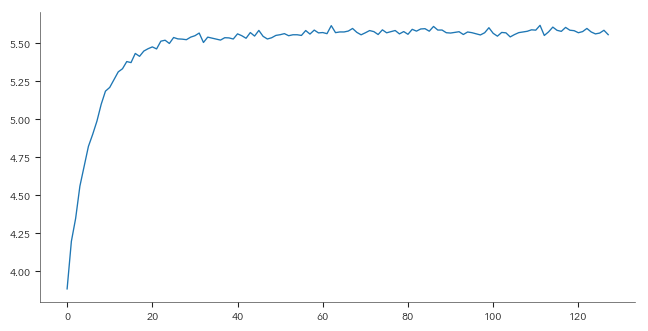

In [10]:
with open('../results/net_clippedste_stetanh.pkl', 'rb') as f:
    metrics = pkl.load(f)
plt.plot(metrics.sdrs)

In [29]:
sdrs = np.stack([bmet_mse.sdrs, bmet_wmse.sdrs, bmet_sp0.sdrs, bmet_wbce.sdrs], axis=1)
sirs = np.stack([bmet_mse.sirs, bmet_wmse.sirs, bmet_sp0.sirs, bmet_wbce.sirs], axis=1)
sars = np.stack([bmet_mse.sars, bmet_wmse.sars, bmet_sp0.sars, bmet_wbce.sars], axis=1)
labels = ['mse', 'weighted mse', 'bce', 'weighted bce']

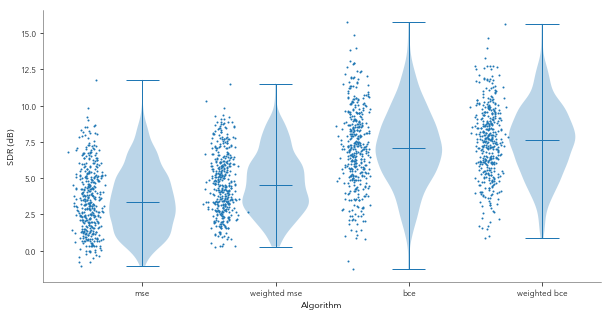

In [38]:
plt.figure(figsize=(10, 5))
plt.violinplot(sdrs, bw_method=.25, showmedians=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sdrs[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SDR (dB)')
plt.savefig('sdrs.png')

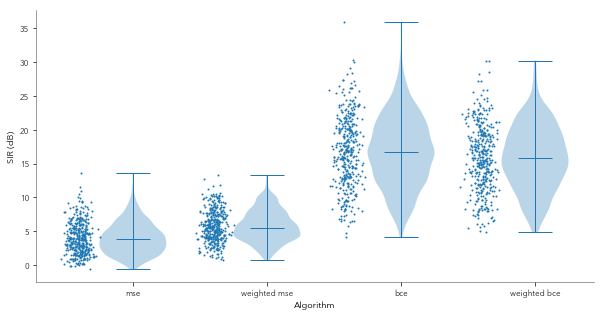

In [39]:
plt.figure(figsize=(10, 5))
plt.violinplot(sirs, bw_method=.25, showmedians=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sirs[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SIR (dB)')
plt.savefig('sirs.png')

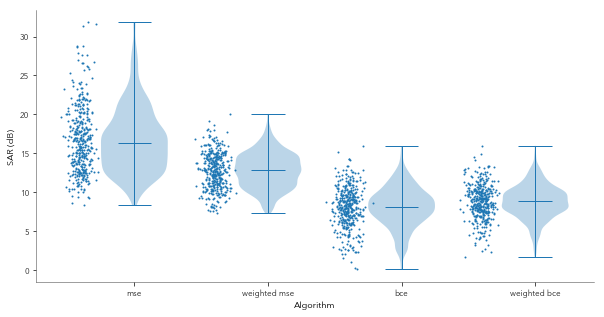

In [40]:
plt.figure(figsize=(10, 5))
plt.violinplot(sars, bw_method=.25, showmedians=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sars[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SAR (dB)')
plt.savefig('sars.png')